In [ ]:
pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 33kB/s 
     |████████████████████████████████| 3.8MB 33.4MB/s 
     |████████████████████████████████| 512kB 41.4MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=14f8114491285e823f358fda6e7be7672c75e4ff6d221c0ee3b43be512d80f3a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensor

# Importing the libraries

In [ ]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import time
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Dataset

In [ ]:
training_file = '/content/drive/MyDrive/Colab Notebooks/MMA/traffic-signs-data/train.p'
testing_file = '/content/drive/MyDrive/Colab Notebooks/MMA/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

assert(len(train['features']) == len(train['labels']))
assert(len(test['features']) == len(test['labels']))

print("'train' and 'test' are dictionaries with keys:", train.keys())
print("'features' in 'train' is a", type(train['features']), "of size", train['features'].shape)
print("'labels' in 'train' is a", type(train['labels']), "of size", train['labels'].shape)
print("'sizes' in 'train' is a", type(train['sizes']), "of size", train['sizes'].shape)
print("'coords' in 'train' is a", type(train['coords']), "of size", train['coords'].shape)

'train' and 'test' are dictionaries with keys: dict_keys(['sizes', 'coords', 'features', 'labels'])
'features' in 'train' is a <class 'numpy.ndarray'> of size (39209, 32, 32, 3)
'labels' in 'train' is a <class 'numpy.ndarray'> of size (39209,)
'sizes' in 'train' is a <class 'numpy.ndarray'> of size (39209, 2)
'coords' in 'train' is a <class 'numpy.ndarray'> of size (39209, 4)


In [ ]:
# Number of training, validation, and test examples, image resolution and color channels and number of classification classes
n_train = len(train['features'])
n_test = len(test['features'])
image_shape = train['features'][0,:,:,:].shape

train_unique, train_counts = np.unique(train['labels'], return_counts='True')
test_unique, test_counts = np.unique(test['labels'], return_counts='True')
n_classes_train = len(train_unique)
n_classes_test = len(test_unique)

print("Number of training examples =", n_train)
print("Number of test examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes in the training set =", n_classes_train)
print("Number of classes in the test set =", n_classes_test)

Number of training examples = 39209
Number of test examples = 12630
Image data shape = (32, 32, 3)
Number of classes in the training set = 43
Number of classes in the test set = 43


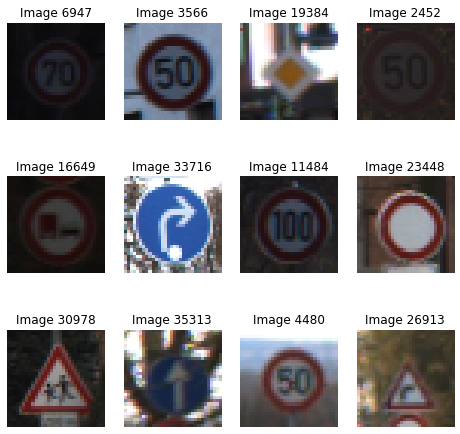

In [ ]:
grid_m = 3
grid_n = 4
rand_grid = np.random.randint(n_train, size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,8))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(train['features'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MMA/traffic-signs-data/signnames.csv')
df

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [ ]:
train_pcent = np.around(np.array([i/n_train for i in train_counts])*100, 1)
test_pcent = np.around(np.array([np.around(i/n_test, 3) for i in test_counts])*100, 1)

with open('/content/drive/MyDrive/Colab Notebooks/MMA/traffic-signs-data/signnames.csv', newline='') as csvfile:
    csvread = csv.reader(csvfile, delimiter=',')
    signtable = {i[0]:i[1] for i in csvread}
signnames = [signtable[str(train_unique[i])] for i in train_unique]

n_tracks_train = (train_counts / 30).astype(int)
n_tracks_test = (test_counts / 30).astype(int)

class_table = np.array([train_unique, signnames, n_tracks_train, train_counts, train_pcent, n_tracks_test, test_counts, test_pcent]).T

np.set_printoptions(suppress=True, precision=1) # suppress scientific data format for printing because it's not very readable
print(['Class Id', 'Desc.', '# Tracks Train', '# Train', '% Train', '# Tracks Test', '# Test', '% Test'])
print(class_table)


['Class Id', 'Desc.', '# Tracks Train', '# Train', '% Train', '# Tracks Test', '# Test', '% Test']
[['0' ' Speed limit (20km/h)' '7' '210' '0.6' '2' '60' '0.5']
 ['1' ' Speed limit (30km/h)' '74' '2220' '6.1' '24' '720' '5.7']
 ['2' ' Speed limit (50km/h)' '75' '2250' '6.1' '25' '750' '5.9']
 ['3' ' Speed limit (60km/h)' '47' '1410' '3.8' '15' '450' '3.6']
 ['4' ' Speed limit (70km/h)' '66' '1980' '5.4' '22' '660' '5.2']
 ['5' ' Speed limit (80km/h)' '62' '1860' '5.1' '21' '630' '5.0']
 ['6' ' End of speed limit (80km/h)' '14' '420' '1.1' '5' '150' '1.2']
 ['7' ' Speed limit (100km/h)' '48' '1440' '3.9' '15' '450' '3.6']
 ['8' ' Speed limit (120km/h)' '47' '1410' '3.8' '15' '450' '3.6']
 ['9' ' No passing' '49' '1470' '4.0' '16' '480' '3.8']
 ['10' ' No passing for vehicles over 3.5 metric tons' '67' '2010' '5.5'
  '22' '660' '5.2']
 ['11' ' Right-of-way at the next intersection' '44' '1320' '3.6' '14'
  '420' '3.3']
 ['12' ' Priority road' '70' '2100' '5.7' '23' '690' '5.5']
 ['13' ' 

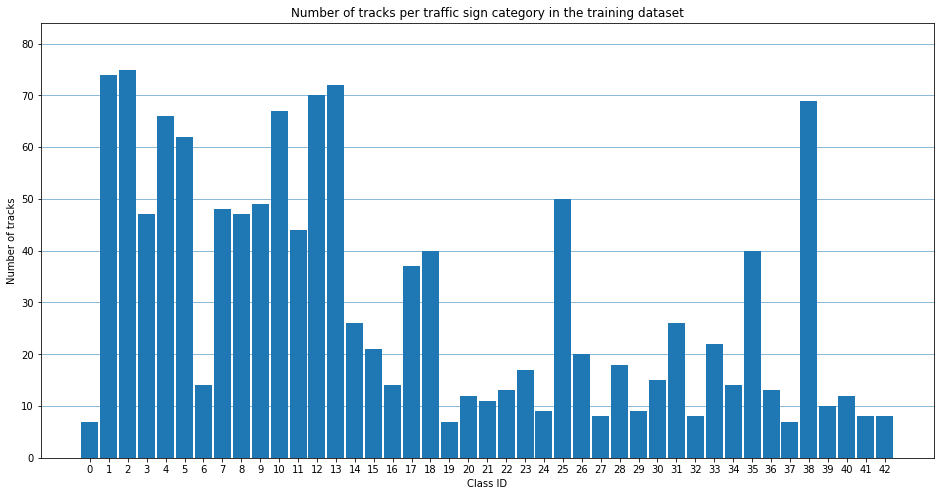

In [ ]:
f1, cell1 = plt.subplots(figsize=(16,8))
cell1.bar(range(len(n_tracks_train)), n_tracks_train, width=0.9)
cell1.set_ylabel("Number of tracks")
cell1.set_xlabel("Class ID")
cell1.set_xticks(np.arange(0,43,1))
cell1.set_title("Number of tracks per traffic sign category in the training dataset")
for ymaj in cell1.yaxis.get_majorticklocs():
    cell1.axhline(y=ymaj, linewidth=0.5)

# Creating a validation dataset

In [ ]:
def val_split(features, labels, sizes, coords, n_pick=2, n_imgs_per_track=30):
    
    #Get the number of classes and the number of samples for each class
    train_unique, train_counts = np.unique(labels, return_counts='True')

    n_tracks = (train_counts / n_imgs_per_track).astype(int) 
    
    #Calculate a list of the cumulative number of images in all classes.
    cum_imgs_per_class = np.zeros(len(train_unique), dtype='int')
    for k in range(1, len(train_unique)):
        cum_imgs_per_class[k:] += train_counts[k-1]

    val_indices = np.array([], dtype='int')
    for c in range(len(train_unique)): 
        val_tracks = random.sample(range(n_tracks[c]), n_pick) 
        for k in val_tracks: 
            start = cum_imgs_per_class[c] + n_imgs_per_track * k 
            end = start + n_imgs_per_track
            val_indices = np.hstack((val_indices, np.r_[start:end]))  
    
    val_features = np.take(features, val_indices, 0)
    val_labels = np.take(labels, val_indices, 0)
    val_sizes = np.take(sizes, val_indices, 0)
    val_coords = np.take(coords, val_indices, 0)

    train_features = np.take(features, sorted(set(range(len(features)))-set(val_indices)), 0)
    train_labels = np.take(labels, sorted(set(range(len(labels)))-set(val_indices)), 0)
    train_sizes = np.take(sizes, sorted(set(range(len(sizes)))-set(val_indices)), 0)
    train_coords = np.take(coords, sorted(set(range(len(coords)))-set(val_indices)), 0)
    
    return (train_features,
            train_labels,
            train_sizes,
            train_coords,
            val_features,
            val_labels,
            val_sizes,
            val_coords)

In [ ]:
#Split off the validation dataset.
train_features, train_labels, train_sizes, train_coords, val_features, val_labels, val_sizes, val_coords = val_split(train['features'],
                                                                                                                     train['labels'],
                                                                                                                     train['sizes'],
                                                                                                                     train['coords'])

np.save('./val_features', val_features)
np.save('./val_labels', val_labels)
np.save('./val_sizes', val_sizes)
np.save('./val_coords', val_coords)

np.save('./train_features', train_features)
np.save('./train_labels', train_labels)
np.save('./train_sizes', train_sizes)
np.save('./train_coords', train_coords)

print("Training and validation datasets created and saved to disk.")
print()

n_train = len(train_features)
n_val = len(val_features)
n_test = len(test['features'])
image_shape = train_features[0,:,:,:].shape
n_classes = len(train_unique)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes in the training set =", n_classes)

Training and validation datasets created and saved to disk.

Number of training examples = 36629
Number of validation examples = 2580
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes in the training set = 43


In [ ]:
train_features = np.load('./train_features.npy')
train_labels = np.load('./train_labels.npy')
val_features = np.load('./val_features.npy')
val_labels = np.load('./val_labels.npy')

testing_file = '/content/drive/MyDrive/Colab Notebooks/MMA/traffic-signs-data/test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Data Augmentation

In [ ]:
def perspective_transform(image, orientation='rand'):
    
    rows,cols,ch = image.shape
    
    k=3
    
    choices = [[5,5,5,5],
              [5,5,k,5+k]]
    choice = random.choice(choices)
    
    hdistl = choice[0] 
    hdistr = choice[1] 
    vdistt = choice[2] 
    vdistb = choice[3] 
    #Generate the point sets depending on the orientation passed.
    if orientation == 'rand':
        orientation = random.choice(['left', 'right'])
    
    if orientation == 'left':
        pts1 = np.float32([[0,k],[cols,k],[0,rows-k],[cols,rows-k]])
        pts2 = np.float32([[hdistl,vdistt],[cols-hdistr,0],[hdistl,rows-vdistb],[cols-hdistr,rows]])
    elif orientation == 'right':
        pts1 = np.float32([[0,k],[cols,k],[0,rows-k],[cols,rows-k]])
        pts2 = np.float32([[hdistl,0],[cols-hdistr,vdistt],[hdistl,rows],[cols-hdistr,rows-vdistb]])
    else: raise ValueError("No or unknown orientation given. Possible values are 'left' and 'right'.")
    
    #Calculate the transformation matrix, perform the transformation, and return it.
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image, M, (rows, cols))

def rotate(image, min=5, max=15, orientation='rand'):
    
    rows,cols,ch = image.shape
    
    random_rot = np.random.randint(min, max+1)
    
    if orientation == 'rand':
        rotation_angle = random.choice([-random_rot, random_rot])
    elif orientation == 'left':
        rotation_angle = random_rot
    elif orientation == 'right':
        rotation_angle = -random_rot
    else:
        raise ValueError("Orientation is optional and can only be 'left' or 'right'.")
    
    M = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle, 1)
    return cv2.warpAffine(image, M, (cols, rows))

def translate(image, min=2, max=2):
    
    rows,cols,ch = image.shape
    
    x = np.random.randint(min, max+1)
    y = np.random.randint(min, max+1)
    x_shift = random.choice([-x, x])
    y_shift = random.choice([-y, y])
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

def scale(image, min=0.9, max=1.1):
    
    rows,cols,ch = image.shape
    
    scale = np.random.uniform(min, max)
    
    M = cv2.getRotationMatrix2D((cols/2,rows/2), 0, scale)
    return cv2.warpAffine(image, M, (cols, rows))

def brightness(image, min=0.5, max=2.0):
    
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    random_br = np.random.uniform(min,max)
    
    mask = hsv[:,:,2]*random_br > 255
    v_channel = np.where(mask, 255, hsv[:,:,2]*random_br)
    hsv[:,:,2] = v_channel
    
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

def histogram_eq(image):
    
    image1 = np.copy(image)
    
    image1[:,:,0] = cv2.equalizeHist(image1[:,:,0])
    image1[:,:,1] = cv2.equalizeHist(image1[:,:,1])
    image1[:,:,2] = cv2.equalizeHist(image1[:,:,2])
    
    return image1

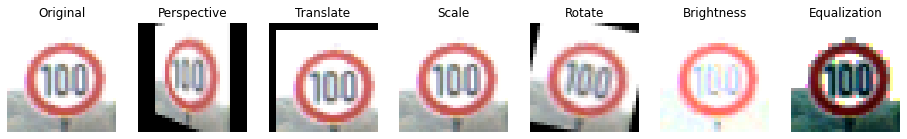

In [ ]:
image = train_features[10000]

transform_exmpl = [image,
                   perspective_transform(image),
                   translate(image),
                   scale(image),
                   rotate(image, min=10),
                   brightness(image),
                   histogram_eq(image)]

transform_descs = ['Original', 'Perspective', 'Translate', 'Scale', 'Rotate', 'Brightness', 'Equalization']

f2, cell2 = plt.subplots(1, 7, figsize=(16,6))
for i in range(7):
    cell2[i].imshow(transform_exmpl[i])
    cell2[i].axis('off')
    cell2[i].set_title(transform_descs[i])

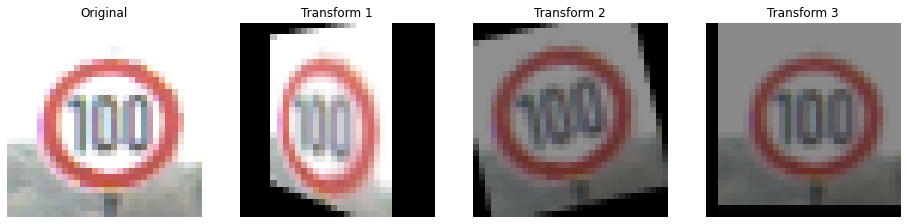

In [ ]:
# Transform 1: Scale -> Translate -> Perspective Transform
transform1_exmpl = np.array([perspective_transform(translate(scale(image))) for image in train_features[10000:10001]])

# Transform 2: Brightness -> Translate -> Rotate
transform2_exmpl = np.array([rotate(translate(brightness(image))) for image in train_features[10000:10001]])

# Transform 3: Brightness -> Scale -> Translate
transform3_exmpl = np.array([translate(scale(brightness(image)), 0, 2) for image in train_features[10000:10001]])

transform_exmpl2 = [train_features[10000], transform1_exmpl[0], transform2_exmpl[0], transform3_exmpl[0]]
transform_exmpl2_descs = ['Original', 'Transform 1', 'Transform 2', 'Transform 3']

f3, cell13 = plt.subplots(1, 4, figsize=(16,6))
for i in range(4):
    cell13[i].imshow(transform_exmpl2[i])
    cell13[i].axis('off')
    cell13[i].set_title(transform_exmpl2_descs[i])

In [ ]:
# Produce the jittered datasets and save them to disk.
# Since the order of the images is left unchanged, we don't need to produce new label sets.

transform1_features = np.array([perspective_transform(translate(scale(image))) for image in train_features])
transform2_features = np.array([rotate(translate(brightness(image))) for image in train_features])
transform3_features = np.array([translate(scale(brightness(image)), 0, 2) for image in train_features])

np.save('./transform1_features', transform1_features)
np.save('./transform2_features', transform2_features)
np.save('./transform3_features', transform3_features)

In [ ]:

#transform1_features = np.load('./transform1_features.npy')
transform2_features = np.load('./transform2_features.npy')
transform3_features = np.load('./transform3_features.npy')


augmented_training_features = np.concatenate((train_features,
                                              transform2_features,
                                              transform3_features))

augmented_training_labels = np.concatenate((train_labels,
                                            train_labels,
                                            train_labels))

assert(len(augmented_training_features) == len(augmented_training_labels))
print("Number of training examples in the augmented training dataset: {}".format(len(augmented_training_features)))
print("Format of the augmented training features: {}".format(augmented_training_features.shape))
print("Format of the augmented training labels: {}".format(augmented_training_labels.shape))

Number of training examples in the augmented training dataset: 109887
Format of the augmented training features: (109887, 32, 32, 3)
Format of the augmented training labels: (109887,)


# Data Preprocessing

In [ ]:
# Convert the training, validation, and test datasets from RGB to grayscale.
train_features_gray = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in augmented_training_features]), 3)
val_features_gray = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in val_features]), 3)
test_features_gray = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in test['features']]), 3)

X_train, y_train = train_features_gray / 127.5 - 1, augmented_training_labels
X_val, y_val = val_features_gray / 127.5 - 1, val_labels
X_test, y_test = test_features_gray / 127.5 - 1, test['labels']

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

# Training the model

In [ ]:
# Define a batch normalization function that can distinguish between training and inference.

def batch_normalization(x, is_training, offset, scale, pop_mean, pop_var, layer_type, decay=0.99): 
    
    return tf.cond(is_training,
                   lambda: train_normalize(x, offset, scale, pop_mean, pop_var, layer_type, decay),
                   lambda: inference_normalize(x, pop_mean, pop_var, offset, scale))

def train_normalize(x, offset, scale, pop_mean, pop_var, layer_type, decay):
    epsilon = 1e-4
    if layer_type=='conv':
        batch_mean, batch_var = tf.nn.moments(x, axes=[0, 1, 2])
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, offset, scale, epsilon)
    elif layer_type=='fc':
        batch_mean, batch_var = tf.nn.moments(x, axes=[0])
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, offset, scale, epsilon)
    else: raise ValueError("No or unknown layer type given. Supported layer types are convolutional ('conv') and fully connected ('fc').")

def inference_normalize(x, pop_mean, pop_var, offset, scale):
    epsilon = 1e-4
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, epsilon)

In [ ]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_X, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(acc, feed_dict={X: batch_X, y: batch_y, keep_prob: 1.0, is_training: False})
        total_accuracy += (accuracy * len(batch_X))
    return total_accuracy / num_examples

In [ ]:
def build_graph_p2():
    
    ilr_BN = 0.002 #The initial learning rate
    global_step_BN = tf.Variable(0, trainable=False) 
    learning_rate_BN = tf.train.exponential_decay(ilr_BN, global_step_BN, decay_steps=800, decay_rate=0.9, staircase=True)
    
    #L2 regularization factor
    lmbda_BN = 0.0005
    
    n_input_channels = 1 #The number of color channels of the input data
    
    #The depth of each layer.
    layer_depth = {'conv1': 108,
                   'conv2': 200,
                   'fc1': 100,
                   'fc2': 43}
    
    #The convolutional filter size. 
    fsize = {
        '1': 5,
        '2': 5
    }
    
    #The convolutional stride and max pooling ksize are the same for all layers
    conv_stride = 1
    pool_k = 2
    
    #Placeholders for the is_training flag.
    is_training = tf.placeholder(tf.bool)
    
    #Placeholders for the inputs.
    X = tf.placeholder(tf.float32, (None, 32, 32, n_input_channels))
    y = tf.placeholder(tf.int32, (None))
    y_one_hot = tf.one_hot(y, 43)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x108.
    conv1_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['1'], fsize['1'], n_input_channels, layer_depth['conv1']), stddev = 1/(fsize['1']*np.sqrt(n_input_channels/2))))
    conv1_beta = tf.Variable(tf.zeros(layer_depth['conv1'])) #Scale for batch normalization. 
    conv1_gamma = tf.Variable(tf.ones(layer_depth['conv1'])) #Offset for batch normalization. 
    conv1_pop_mean = tf.Variable(tf.zeros(layer_depth['conv1']), trainable=False) #An estimator of the population mean.
    conv1_pop_var = tf.Variable(tf.ones(layer_depth['conv1']), trainable=False) #An estimator of the population variance.
    conv1_BN = tf.nn.conv2d(X, conv1_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    conv1_BN = batch_normalization(conv1_BN, is_training, conv1_beta, conv1_gamma, conv1_pop_mean, conv1_pop_var, layer_type='conv')
    conv1_BN = tf.nn.relu(conv1_BN)

    # Pooling. Input = 28x28x108. Output = 14x14x108.
    conv1_BN = tf.nn.max_pool(conv1_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Layer 2: Convolutional. Input = 14x14x108. Output = 10x10x200.
    conv2_W_BN = tf.Variable(tf.truncated_normal(shape=(fsize['2'], fsize['2'], layer_depth['conv1'], layer_depth['conv2']), stddev = 1/(fsize['2']*np.sqrt(layer_depth['conv1']/2))))
    conv2_beta = tf.Variable(tf.zeros(layer_depth['conv2']))
    conv2_gamma = tf.Variable(tf.ones(layer_depth['conv2']))
    conv2_pop_mean = tf.Variable(tf.zeros(layer_depth['conv2']), trainable=False)
    conv2_pop_var = tf.Variable(tf.ones(layer_depth['conv2']), trainable=False)
    conv2_BN = tf.nn.conv2d(conv1_BN, conv2_W_BN, [1,conv_stride,conv_stride,1], padding='VALID')
    conv2_BN = batch_normalization(conv2_BN, is_training, conv2_beta, conv2_gamma, conv2_pop_mean, conv2_pop_var, layer_type='conv')
    conv2_BN = tf.nn.relu(conv2_BN)
    
    # Pooling. Input = 10x10x200. Output = 5x5x200.
    conv2_BN = tf.nn.max_pool(conv2_BN, ksize=[1,pool_k,pool_k,1], strides=[1,pool_k,pool_k,1], padding='VALID')
    
    # Flatten. Input = 5x5x200. Output = 5,000.
    fc0_BN = flatten(conv2_BN)
    
    # Layer 3: Fully Connected. Input = 5,000. Output = 100.
    fc1_W_BN = tf.Variable(tf.truncated_normal(shape=(5*5*layer_depth['conv2'],layer_depth['fc1']), stddev = 1/np.sqrt(5*5*layer_depth['conv2']/2)))
    fc1_beta = tf.Variable(tf.zeros(layer_depth['fc1']))
    fc1_gamma = tf.Variable(tf.ones(layer_depth['fc1']))
    fc1_pop_mean = tf.Variable(tf.zeros(layer_depth['fc1']), trainable=False)
    fc1_pop_var = tf.Variable(tf.ones(layer_depth['fc1']), trainable=False)
    fc1_BN = tf.matmul(fc0_BN, fc1_W_BN)
    fc1_BN = batch_normalization(fc1_BN, is_training, fc1_beta, fc1_gamma, fc1_pop_mean, fc1_pop_var, layer_type='fc')
    fc1_BN = tf.nn.relu(fc1_BN)

    # Layer 4: Fully Connected. Input = 100. Output = 43.
    fc2_W_BN = tf.Variable(tf.truncated_normal(shape=(layer_depth['fc1'],layer_depth['fc2']), stddev = 1/np.sqrt(layer_depth['fc1']/2)))
    fc2_b_BN = tf.Variable(tf.zeros(layer_depth['fc2']))
    logits_BN = tf.matmul(fc1_BN, fc2_W_BN) + fc2_b_BN
    softmax_BN = tf.nn.softmax(logits_BN)
    
    #Softmax with cross entropy loss
    loss_BN = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = logits_BN, labels = y_one_hot)) + lmbda_BN*(tf.nn.l2_loss(conv1_W_BN) + tf.nn.l2_loss(conv2_W_BN) + tf.nn.l2_loss(fc1_W_BN) + tf.nn.l2_loss(fc2_W_BN))
    
    #Adam minimizer
    training_step_BN = tf.train.AdamOptimizer(learning_rate=learning_rate_BN).minimize(loss_BN, global_step=global_step_BN)
    
    #Prediction accuracy op
    correct_prediction_BN = tf.equal(tf.argmax(logits_BN, 1), tf.argmax(y_one_hot, 1))
    accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN, tf.float32))
    
    return (X,
            y,
            is_training,
            keep_prob,
            softmax_BN,
            training_step_BN,
            accuracy_BN,
            correct_prediction_BN,
            tf.train.Saver()
           )

In [ ]:
#Perform the training

epochs = 10
batch_size = 128

start_time = time.time()
tf.reset_default_graph()

p2_model_acc = []
p2_model_acc_steps = []

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

#Run the training session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    k = 0 #Counter for the number of training steps

    print("Training...")
    print()
    for i in range(epochs):
        print("EPOCH {} ...".format(i+1))
        print()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            #Create a mini batch
            end = offset + batch_size
            batch_X, batch_y = X_train[offset:end], y_train[offset:end]
            #Run a training step
            sess.run(training_step, feed_dict={
                X: batch_X,
                y: batch_y,
                keep_prob: 0.5,
                is_training: True})
            k += 1
            
        #Evaluate accuracy
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_val, y_val)
        p2_model_acc.append(validation_accuracy)
        p2_model_acc_steps.append(k)
        print("Number of training steps: {}".format(k))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time elapsed: %s seconds" % round(time.time() - start_time, 0))
        print()
    
    model_name = 'p2_model_02_nodropout_augdata'
    saved_model = saver.save(sess, model_name)
    print("Model saved as {}".format(model_name))
    print()

p2_model_acc = np.array(p2_model_acc)
p2_model_acc_steps = np.array(p2_model_acc_steps)
np.save('./{}_accs'.format(model_name), p2_model_acc)
np.save('./{}_steps'.format(model_name), p2_model_acc_steps)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Training...

EPOCH 1 ...

Number of training steps: 859
Training Accuracy = 0.957
Validation Accuracy = 0.928
Time elapsed: 1470.0 seconds

EPOCH 2 ...

Number of training steps: 1718
Training Accuracy = 0.986
Validation Accuracy = 0.953
Time elapsed: 2963.0 seconds

EPOCH 3 ...

Number of training steps: 2577
Training Accuracy = 0.985
Validation Accuracy = 0.934
Time elapsed: 4441.0 seconds

EPOCH 4 ...

Number of training steps: 3436
Training Accuracy = 0.992
Validation Accuracy = 0.956
Time elapsed: 5916.0 seconds

EPOCH 5 ...

Number of training steps: 4295
Training Accuracy = 0.997
Validation Accuracy = 0.950
Time elapsed: 7393.0 seconds

EPOCH 6 ...

Number of tr


Final accuracy on the validation dataset = 0.957



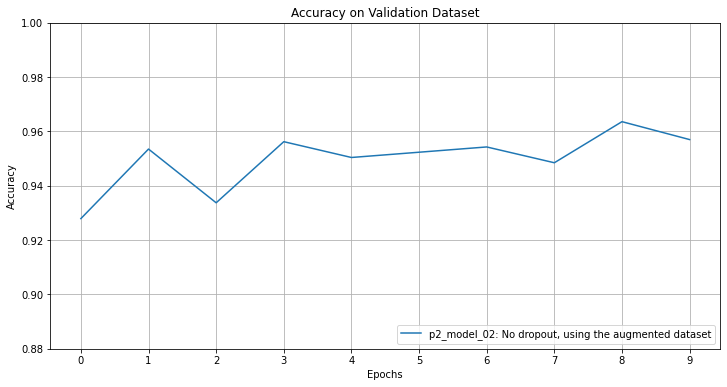

In [ ]:
#Plot the accuracies on the validation dataset

p2_model_02_nodropout_augdata = np.load('./p2_model_02_nodropout_augdata_accs.npy')

print()
print("Final accuracy on the validation dataset = {:.3f}".format(p2_model_02_nodropout_augdata[-1]))
print()

fig5, ax5 = plt.subplots(figsize=(12,6))

ax5.plot(range(0,len(p2_model_02_nodropout_augdata)), p2_model_02_nodropout_augdata, label='p2_model_02: No dropout, using the augmented dataset')
ax5.set_xlabel('Epochs')
ax5.set_xticks(range(0,len(p2_model_02_nodropout_augdata),1))
ax5.set_ylabel('Accuracy')
ax5.set_ylim([0.88,1])
ax5.set_title('Accuracy on Validation Dataset')
ax5.legend(loc=4)
ax5.grid(True)

plt.show()

In [ ]:
# Evaluate the model on the test dataset

tf.reset_default_graph()

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

with tf.Session() as sess:
    saver.restore(sess, './p2_model_02_nodropout_augdata')
    test_accuracy = evaluate(X_test, y_test)
    print()
    print("Accuracy on the test dataset = {:.3f}".format(test_accuracy))
    print()

INFO:tensorflow:Restoring parameters from ./p2_model_02_nodropout_augdata

Accuracy on the test dataset = 0.976



# Testing the model

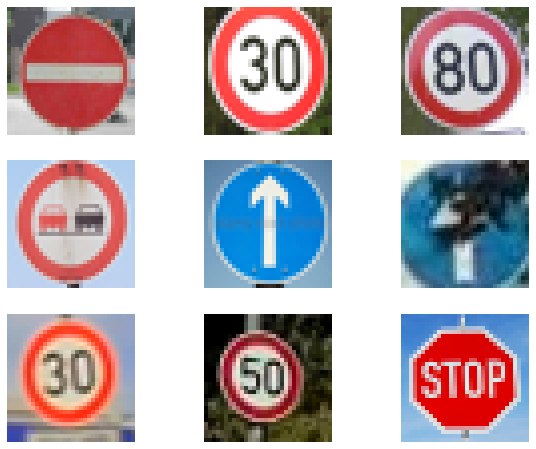

In [ ]:
from PIL import Image
import glob

testimgs = []
filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/MMA/traffic-signs-data/images/*.png')
filelist = sorted(filelist)

for filename in filelist:
    with Image.open(filename) as img:
        arr = np.array(img)
        testimgs.append(arr)

f4, cell4 = plt.subplots(3, 3, figsize=(10,8))
for i in range(3):
    for j in range(3):
        cell4[i, j].imshow(testimgs[3*i+j])
        cell4[i, j].axis('off')

#Convert to grayscale
X_home = np.expand_dims(np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in testimgs]),3) #- channel_mean
y_home = np.array([17,1,5,9,35,35,1,2,14])

INFO:tensorflow:Restoring parameters from ./p2_model_02_nodropout_augdata
Accuracy on my own images = 0.556

The following images were classified incorrectly:



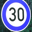

was incorrectly classified as  Speed limit (30km/h), while it actually is  Speed limit (30km/h).


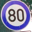

was incorrectly classified as  Speed limit (50km/h), while it actually is  Speed limit (80km/h).


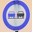

was incorrectly classified as  Speed limit (60km/h), while it actually is  No passing.


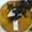

was incorrectly classified as  Speed limit (80km/h), while it actually is  Ahead only.


In [ ]:
from PIL import Image as im
from google.colab.patches import cv2_imshow
tf.reset_default_graph()

#Build the graph
X, y, is_training, keep_prob, softmax, training_step, acc, correct_prediction, saver = build_graph_p2()

with tf.Session() as sess:
    saver.restore(sess, './p2_model_02_nodropout_augdata')
    res2 = sess.run([softmax,
                     correct_prediction,
                     tf.nn.top_k(softmax, k=3)],
                    feed_dict={X: X_home,
                               y: y_home,
                               is_training: False,
                               keep_prob: 1})
    home_accuracy = np.mean(res2[1].astype(np.int32))
    print("Accuracy on my own images = {:.3f}".format(home_accuracy))
    print()

print("The following images were classified incorrectly:")
print()

#Find the indices of the images that were classified incorrectly.
incorrect_inds = np.squeeze(np.argwhere(res2[1]==False))

for k in range(len(incorrect_inds)):
    j = incorrect_inds[k]
    cv2_imshow(testimgs[incorrect_inds[k]])
    print("was incorrectly classified as {}, while it actually is {}.".format(signnames[j], signnames[y_home[j]]))